<a href="https://colab.research.google.com/github/kkk79/testDeep/blob/main/Deep_Learning_NextWordPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import nltk
import string
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
import os
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
import matplotlib.pyplot as plt
import pickle
import heapq


drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Colab Notebooks'


Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [ ]:
path='/content/drive/My Drive/Colab Notebooks/Comments/ArticlesMarch2017.csv'
text=pd.read_csv(path)
print('corpus length:', len(text))
text.head()


corpus length: 949


,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,5adb8334068401528a2a9f74,1571,By THE EDITORIAL BOARD,article,The Opioid Crisis Foretold,"['Opioids and Opiates', 'Drug Abuse and Traffi...",68,Editorial,10,2018-04-21 18:30:10,Sunday Review,History supplies precedents and lessons for th...,The New York Times,Editorial,https://www.nytimes.com/2018/04/21/opinion/an-...
1,NaN,5adb8331068401528a2a9f70,1221,By PETER FRITSCH and GLENN R. SIMPSON,article,The Business Deals That Could Imperil Trump,['Russian Interference in 2016 US Elections an...,68,OpEd,3,2018-04-21 18:30:06,Sunday Review,Forget Stormy Daniels. The business records su...,The New York Times,Op-Ed,https://www.nytimes.com/2018/04/21/opinion/sun...
2,NaN,5adb8330068401528a2a9f6f,1465,By CHRISTOPHER A. PREBLE,article,Adapting to American Decline,"['United States International Relations', 'Uni...",68,OpEd,1,2018-04-21 18:30:05,Sunday Review,The United States is losing its influence as i...,The New York Times,Op-Ed,https://www.nytimes.com/2018/04/21/opinion/sun...
3,NaN,5adb8330068401528a2a9f6d,1097,By FRANK BRUNI,article,The Republicans’ Big Senate Mess,"['United States Politics and Government', 'Ele...",67,OpEd,3,2018-04-21 18:30:04,Sunday Review,"A convict in West Virginia, bondage in Missour...",The New York Times,Op-Ed,https://www.nytimes.com/2018/04/21/opinion/sun...
4,NaN,5adb8330068401528a2a9f6e,1306,By SHARON LERNER,article,States Are Doing What Scott Pruitt Won’t,"['Water Pollution', 'Hazardous and Toxic Subst...",68,OpEd,2,2018-04-21 18:30:04,Sunday Review,The federal government may ignore the environm...,The New York Times,Op-Ed,https://www.nytimes.com/2018/04/21/opinion/sun...


In [ ]:
print("Number of records: ", text.shape[0])
print ("Number of fields: ", text.shape[1])


Number of records:  949
Number of fields:  16


In [ ]:
#combine all the snippets into a series of strings
snippet = '\n'.join(text["snippet"])
text=snippet.lower()
print(snippet)

History supplies precedents and lessons for the opioid epidemic raging in America today — but we seem to have largely forgotten both.
Forget Stormy Daniels. The business records subpoenaed by Robert Mueller might be Donald Trump’s greatest legal headache.
The United States is losing its influence as its relative power erodes. How should it manage the transition without destabilizing everyone else?
A convict in West Virginia, bondage in Missouri and a wacky contest for control of the chamber.
The federal government may ignore the environment, but we can’t afford to.
With the blunt and plain-spoken and often funny Barbara Bush, you always knew where you stood.
White people who see black people through racism’s lens can often count on the police to share their outlook.
Mel Taub is back with some head-spinners.
The E.P.A. chief is under scrutiny for high spending and interactions with lobbyists. Many of the pitfalls he has encountered in Washington have echoes in his past.
False rumors set

In [ ]:
# the text contains 949 unique snippets
text = snippet.lower().split('\n')
print(text[:2]) #snippets


['history supplies precedents and lessons for the opioid epidemic raging in america today — but we seem to have largely forgotten both.', 'forget stormy daniels. the business records subpoenaed by robert mueller might be donald trump’s greatest legal headache.']


In [ ]:
# Split into each word. Kera's tokenizer also ranges them ( 1 is the most frequent word) This text has 5168unique words
tokenizer=Tokenizer ()
tokenizer.fit_on_texts(text)
word_index=tokenizer.word_index
total_unique_words=len(tokenizer.word_index) + 1
print(total_unique_words)
print(word_index)
print ("Toxic: ", tokenizer.word_index['toxic'])

5168
{'the': 1, 'a': 2, 'to': 3, 'and': 4, 'of': 5, 'in': 6, 'is': 7, 'for': 8, 'on': 9, 'that': 10, 'with': 11, 'as': 12, 'are': 13, 'it': 14, 'has': 15, 'but': 16, 'have': 17, 'be': 18, 'an': 19, 'new': 20, 'his': 21, 'what': 22, 'president': 23, 'you': 24, 'at': 25, 'from': 26, 'about': 27, 'trump': 28, 'this': 29, 'by': 30, 'or': 31, 'their': 32, 'was': 33, 'more': 34, 'can': 35, 'not': 36, 'do': 37, 'who': 38, 'how': 39, '—': 40, 'some': 41, 'than': 42, 'they': 43, 'he': 44, 'our': 45, 'will': 46, 'may': 47, 'up': 48, 'after': 49, 'its': 50, 'we': 51, 'your': 52, '”': 53, 'people': 54, 'into': 55, 'should': 56, 'many': 57, 'i': 58, 'would': 59, 'one': 60, 'had': 61, 'like': 62, 'make': 63, 'so': 64, 'times': 65, 'life': 66, 'even': 67, 'when': 68, 'care': 69, 'house': 70, 'trump’s': 71, 'health': 72, 'over': 73, 'why': 74, 'her': 75, 'white': 76, 'out': 77, 'us': 78, 'them': 79, 'help': 80, 'could': 81, 'been': 82, 'years': 83, 'if': 84, 'all': 85, 'other': 86, 'first': 87, 'plan'

In [ ]:
# our dataset doesnot have labeled values, so we will use n_gram
# we will apply the text_to_sequences method to each snippet.
input_sequences=[]
for line in text:
  token_list=tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
      n_gram_seqs=token_list[:i+1]
      input_sequences.append(n_gram_seqs)
 

In [ ]:
#n_grams should be on the same length 
max_sequence_len=max([len(x) for x in input_sequences])
input_seqs=np.array(pad_sequences (input_sequences, maxlen=max_sequence_len, padding="pre"))
print(max_sequence_len)  # 37
print(input_seqs[:2]) # samples


37
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  122 1841]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  122 1841 1842]]


In [ ]:
# we will make use of a pre-trained word embeddings model "Glove" 6B 50 dimensional arrays
path = '/content/drive/MyDrive/Colab Notebooks/glove.6B.50d.txt'
embeddings_index={}
with open(path) as f:
  for line in f:
    values=line.split()
    word=values[0]
    coeffs=np.array(values[1:], dtype='float32')
    embeddings_index[word] = coeffs
    #dict(list(embeddings_index.items())[0:2])

In [ ]:
#matrix with 5168 unique words X 50 dimensional arrays of Glove
embeddings_matrix = np.zeros((total_unique_words, 50))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector;

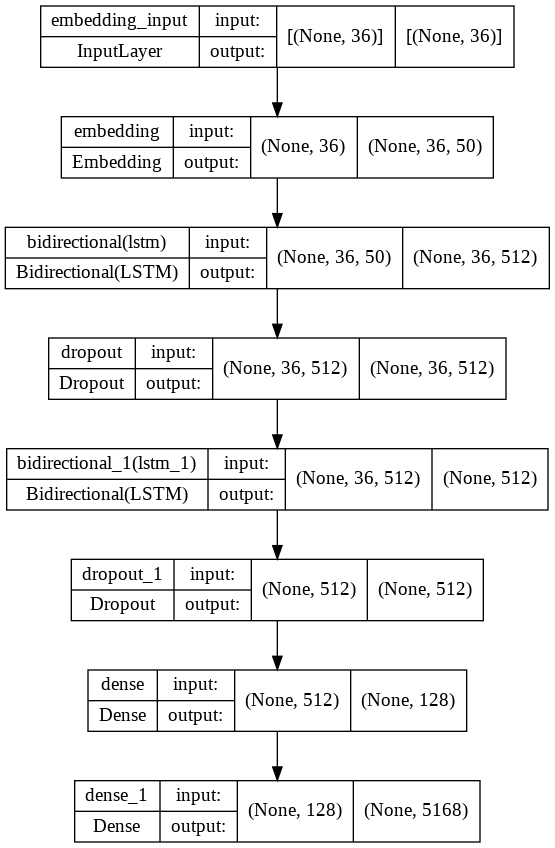

In [ ]:
# Build the model with Bidirectional LSTM
K.clear_session()
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=total_unique_words, output_dim=50, weights=[embeddings_matrix], input_length=max_sequence_len-1, trainable=False), 
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)), 
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(total_unique_words, activation="softmax")])

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

tf.keras.utils.plot_model(model,show_shapes=True)


In [ ]:
# Train the model
x_values, labels = input_seqs[:, :-1], input_seqs[:,-1]
y_values = tf.keras.utils.to_categorical(labels,num_classes=total_unique_words)\

history = model.fit(x_values, y_values, epochs=20, validation_split=0.2, verbose=1, batch_size=128)


Epoch 1/20
105/105 [==============================] - 193s 2s/step - loss: 7.5327 - accuracy: 0.0469 - val_loss: 7.4058 - val_accuracy: 0.0517
Epoch 2/20
105/105 [==============================] - 182s 2s/step - loss: 7.0674 - accuracy: 0.0491 - val_loss: 7.5648 - val_accuracy: 0.0517
Epoch 3/20
105/105 [==============================] - 180s 2s/step - loss: 7.0041 - accuracy: 0.0491 - val_loss: 7.6595 - val_accuracy: 0.0517
Epoch 4/20
105/105 [==============================] - 182s 2s/step - loss: 6.9376 - accuracy: 0.0532 - val_loss: 7.7271 - val_accuracy: 0.0523
Epoch 5/20
105/105 [==============================] - 181s 2s/step - loss: 6.8446 - accuracy: 0.0557 - val_loss: 7.7408 - val_accuracy: 0.0517
Epoch 6/20
105/105 [==============================] - 181s 2s/step - loss: 6.7284 - accuracy: 0.0599 - val_loss: 7.7514 - val_accuracy: 0.0615
Epoch 7/20
105/105 [==============================] - 179s 2s/step - loss: 6.5905 - accuracy: 0.0667 - val_loss: 7.7791 - val_accuracy: 0.0675

In [ ]:
# evaluate the model with not seen text
def prediction(seed_text, next_words):
   for _ in range(next_words):
     token_list = tokenizer.texts_to_sequences([seed_text])[0]
     token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted = np.argmax(model.predict(token_list, verbose=1), axis=-1)
output_word = ""
for word, index in tokenizer.word_index.items():
       if index == predicted:
         output_word = word
         break
         seed_text += " "+ output_word
         print(seed_text)

seed_text = "Government plans"
next_words = len('to restrict'.split())
prediction(seed_text, next_words) 
print(output_word)


1/1 [==============================] - 0s 42ms/step
the


In [ ]:
#save it, tf==27.0
SEQUENCE_LENGTH = 40
model.save('keras_model'+str(SEQUENCE_LENGTH)+" .h5")
pickle.dump(history,open('history'+str(SEQUENCE_LENGTH)+' .p', 'wb'))
model=load_model('keras_model' +str(SEQUENCE_LENGTH)+' .h5')
history = pickle.load(open('history'+str(SEQUENCE_LENGTH)+' .p', 'rb'))


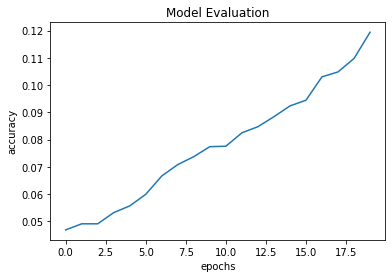

In [ ]:
#Plot loss and accuracy
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.title("Model Evaluation")
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.show
plot_graph(history, 'accuracy')

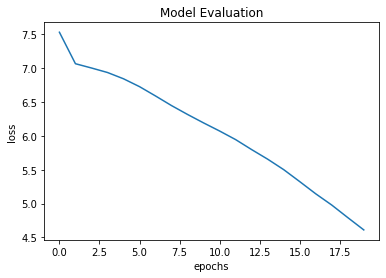

In [ ]:
plot_graph(history, "loss")